In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# параметры распределений
mu0, sigma0 = -2., 1.
mu1, sigma1 = 3., 2.

In [3]:
def sample(d0, d1, n=32):
    x0 = d0.sample((n,))
    x1 = d1.sample((n,))
    y0 = torch.zeros((n, 1))
    y1 = torch.ones((n, 1))
    return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)

In [4]:
d0 = torch.distributions.Normal(torch.tensor([mu0]), torch.tensor([sigma0]))
d1 = torch.distributions.Normal(torch.tensor([mu1]), torch.tensor([sigma1]))

#### визуализируем пример сгенерированного обучающего датасета 

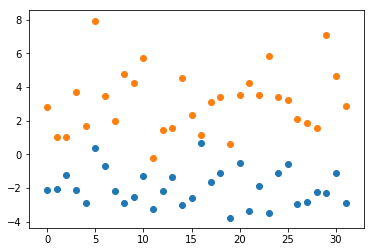

In [5]:
n = 32
plt.scatter(range(n), d0.sample((n,)))
plt.scatter(range(n), d1.sample((n,)));

In [6]:
layer = nn.Linear(1, 1)
print([p.data[0] for p in layer.parameters()])
layer_opt = optim.SGD(lr=1e-3, params=list(layer.parameters()))

[tensor([-0.8126]), tensor(0.2881)]


In [7]:
log_freq = 500
for i in range(10000):
    if i%log_freq == 0:
        # промежуточное валидирование:
        # делаем промежуточный прогноз и считаем на нем ошибку,
        # предварительно отключаем расчет градиентов (для экономии памяти, для предикта он не нужен), 
        # делаем это внутри контекстного менеджера, чтобы не нарушать общий ход вычислений
        # (внутри него это изолируется)
        with torch.no_grad():        
            x, y = sample(d0, d1, 100000)  # делаем валидационную выборку
            out = torch.sigmoid(layer(x))  # предикт (форвард проход)
            loss = F.binary_cross_entropy(out, y)  # функционал ошибки, правдоподобие
        print('Ошибка после %d итераций: %f' %(i/log_freq, loss))
    layer_opt.zero_grad()
    x, y = sample(d0, d1, 1024)  # генерим "на лету" очередной обучающий батч
    out = torch.sigmoid(layer(x))  # прямой проход (форвард), считаем очередное приближение
    loss = F.binary_cross_entropy(out, y)  # функционал-ошибка, который мы оптимизируем
    loss.backward()  # считаем градиенты по каждому параметру (через обратное распространение ошибки)
    layer_opt.step()  # делаем шаг против градиента в соответствие с выбранным алгоритмом "шагания"

Ошибка после 0 итераций: 2.243534
Ошибка после 1 итераций: 0.627230
Ошибка после 2 итераций: 0.353121
Ошибка после 3 итераций: 0.270116
Ошибка после 4 итераций: 0.229751
Ошибка после 5 итераций: 0.208395
Ошибка после 6 итераций: 0.191849
Ошибка после 7 итераций: 0.180767
Ошибка после 8 итераций: 0.172757
Ошибка после 9 итераций: 0.167307
Ошибка после 10 итераций: 0.162584
Ошибка после 11 итераций: 0.158898
Ошибка после 12 итераций: 0.155231
Ошибка после 13 итераций: 0.151899
Ошибка после 14 итераций: 0.150810
Ошибка после 15 итераций: 0.147556
Ошибка после 16 итераций: 0.147248
Ошибка после 17 итераций: 0.144415
Ошибка после 18 итераций: 0.142945
Ошибка после 19 итераций: 0.142459


#### добавим немного хуже обученную модель и сравним кривые

In [8]:
layer1 = nn.Linear(1, 1)
layer_opt1 = optim.SGD(lr=1e-3, params=list(layer1.parameters()))

log_freq = 500
for i in range(2000):
    if i%log_freq == 0:
        # промежуточное валидирование:
        # делаем промежуточный прогноз и считаем на нем ошибку,
        # предварительно отключаем расчет градиентов (для экономии памяти, для предикта он не нужен), 
        # делаем это внутри контекстного менеджера, чтобы не нарушать общий ход вычислений
        # (внутри него это изолируется)
        with torch.no_grad():        
            x, y = sample(d0, d1, 100000)  # делаем валидационную выборку
            out = torch.sigmoid(layer1(x))  # предикт (форвард проход)
            loss = F.binary_cross_entropy(out, y)  # функционал ошибки, правдоподобие
        print('Ошибка после %d итераций: %f' %(i/log_freq, loss))
    layer_opt1.zero_grad()
    x, y = sample(d0, d1, 1024)  # генерим "на лету" очередной обучающий батч
    out = torch.sigmoid(layer1(x))  # прямой проход (форвард), считаем очередное приближение
    loss = F.binary_cross_entropy(out, y)  # функционал-ошибка, который мы оптимизируем
    loss.backward()  # считаем градиенты по каждому параметру (через обратное распространение ошибки)
    layer_opt1.step()  # делаем шаг против градиента в соответствие с выбранным алгоритмом "шагания"

Ошибка после 0 итераций: 1.005532
Ошибка после 1 итераций: 0.468809
Ошибка после 2 итераций: 0.326739
Ошибка после 3 итераций: 0.263811


In [9]:
x_scale = np.linspace(-10, 10, 5000)
d0_pdf = stats.norm.pdf(x_scale, mu0, sigma0) 
d1_pdf = stats.norm.pdf(x_scale, mu1, sigma1)
x_tensor = torch.tensor(x_scale.reshape(-1, 1), dtype=torch.float)
with torch.no_grad():
    dist = torch.sigmoid(layer(x_tensor)).numpy()
    dist1 = torch.sigmoid(layer1(x_tensor)).numpy()
ratio = d1_pdf / (d1_pdf + d0_pdf)

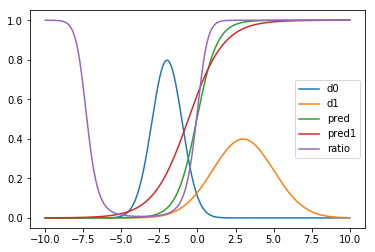

In [10]:
plt.plot(x_scale, d0_pdf*2, label='d0') # умножение на 2 для красоты графиков, на распределения не влияет
plt.plot(x_scale, d1_pdf*2, label='d1')
plt.plot(x_scale, dist.flatten(), label='pred')
plt.plot(x_scale, dist1.flatten(), label='pred1')
plt.plot(x_scale, ratio, label='ratio')
plt.legend();

#### Вывод:
1) Самая уверенная модель - на расчетных распределениях (самый крутой переход от 0 к 1).   
2) Далее - лучше обученная модель - более уверенная (более крутой переход от 0 к 1).  
3) Обученная модель **всегда** хуже расчетной, потому что обучается на выборке, а выборка по определению приближает плотность распределения (конечное число точек)

In [11]:
print([p.data[0] for p in layer.parameters()])

[tensor([1.5062]), tensor(0.0607)]


In [12]:
torch.log(F.sigmoid(torch.tensor(-100.)))

c:\users\dsher\python_venvs\otus_deep_learning_dle-2020-04\venv\lib\site-packages\torch\nn\functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(-inf)

In [13]:
F.logsigmoid(torch.tensor(-100.))

tensor(-100.)